In [1]:
# #| hide
%load_ext autoreload
%autoreload 2

# braga2024datasetname

> Module for handling the loading of bags collected with the INF-UFG car that were previously converted to the Semantic KITTI format.

In [2]:
#| default_exp braga2024datasetname

In [3]:
#| exports
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torch import nn

from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import yaml

from colorcloud.behley2019iccv import ProjectionTransform, ProjectionVizTransform, SphericalProjection, UnfoldingProjection, ProjectionVizTransform

## Parte 1

In [4]:
#| exports
class ufgDataset(Dataset):
    "Load the SemanticKITTI data in a pytorch Dataset object."
    def __init__(self, data_path, split='train', transform=None):
        data_path = Path(data_path)
        yaml_path = data_path/'semantic-kitti.yaml'
        self.velodyne_path = data_path/'dataset/sequences'
        self.labels_path = data_path/'dataset/sequences'

        with open(yaml_path, 'r') as file:
            metadata = yaml.safe_load(file)
        
        sequences = metadata['split'][split]
        velodyne_fns = []
        for seq in sequences:
            velodyne_fns += list(self.velodyne_path.rglob(f'*{seq:02}/velodyne/*.bin'))
        
        self.frame_ids = [fn.stem for fn in velodyne_fns]
        self.frame_sequences = [fn.parts[-3] for fn in velodyne_fns]
        
        self.labels_dict = metadata['labels']
        
        self.content = metadata['content']
        max_key = sorted(self.content.keys())[-1]
        self.content_np = np.zeros((max_key+1,), dtype=np.float32)
        for k, v in self.content.items():
            self.content_np[k] = v
        
        self.learning_map = metadata['learning_map']
        self.learning_map_np = np.zeros((max_key+1,), dtype=np.uint32)
        for k, v in self.learning_map.items():
            self.learning_map_np[k] = v
        
        self.learning_map_inv = metadata['learning_map_inv']
        self.learning_map_inv_np = np.zeros((len(self.learning_map_inv),), dtype=np.uint32)
        self.content_sum_np = np.zeros_like(self.learning_map_inv_np, dtype=np.float32)
        for k, v in self.learning_map_inv.items():
            self.learning_map_inv_np[k] = v
            self.content_sum_np[k] = self.content_np[self.learning_map_np == k].sum()
        
        self.color_map_bgr = metadata['color_map']
        self.color_map_rgb_np = np.zeros((max_key+1, 3), dtype=np.float32)
        for k, v in self.color_map_bgr.items():
            self.color_map_rgb_np[k] = np.array(v[::-1], np.float32)
        
        self.transform = transform
        self.is_test = (split == 'test')
    
    def learning_remap(self, remapping_rules):
        new_map_np = np.zeros_like(self.learning_map_np, dtype=np.uint32)
        max_key = sorted(remapping_rules.values())[-1]
        new_map_inv_np = np.zeros((max_key+1,), dtype=np.uint32)
        for k, v in remapping_rules.items():
            new_map_np[self.learning_map_np == k] = v
            if new_map_inv_np[v] == 0:
                new_map_inv_np[v] = self.learning_map_inv_np[k]
        
        new_content_sum_np = np.zeros_like(new_map_inv_np, dtype=np.float32)
        for k in range(len(new_map_inv_np)):
            new_content_sum_np[k] = self.content_np[new_map_np == k].sum()
        
        self.learning_map_np = new_map_np
        self.learning_map_inv_np = new_map_inv_np
        self.content_sum_np = new_content_sum_np
    
    def set_transform(self, transform):
        self.transform = transform
    
    def __len__(self):
        return len(self.frame_ids)

    def __getitem__(self, idx):
        frame_id = self.frame_ids[idx]
        frame_sequence = self.frame_sequences[idx]
        
        frame_path = self.velodyne_path/frame_sequence/'velodyne'/(frame_id + '.bin')
        with open(frame_path, 'rb') as f:
            frame = np.fromfile(f, dtype=np.float32).reshape(-1, 4)
        
        label = None
        mask = None
        weight = None
        if not self.is_test:
            label_path = self.labels_path/frame_sequence/'labels'/(frame_id + '.label')
            with open(label_path, 'rb') as f:
                label = np.fromfile(f, dtype=np.uint32)
                label = label & 0xFFFF
            label = self.learning_map_np[label]
            mask = label != 0   # see the field *learning_ignore* in the yaml file
            weight = 1./self.content_sum_np[label]
        
        # normalizing the reflectance values (which are between 0 and 255).
        frame[:,3] = frame[:,3]/255

        item = {
            'frame': frame,
            'label': label,
            'mask': mask,
            'weight': weight
        }
        if self.transform:
            item = self.transform(item)
        
        return item

In [5]:
#| eval: false
data_path = '/workspace/data/teste'
ds = ufgDataset(data_path)
val_ds = ufgDataset(data_path, split='valid')
test_ds = ufgDataset(data_path, split='test')
print(f'train size:\t{len(ds)}\nval size:\t{len(val_ds)}\ntest size:\t{len(test_ds)}')

train size:	200
val size:	0
test size:	0


In [6]:
#| eval: false
item = ds[1]
frame = item['frame']
mask = item['mask']
frame, frame.shape

(array([[-2.156321  , -5.562208  , -1.5984664 ,  0.14117648],
        [-2.5282357 , -6.5148077 , -1.6133491 ,  0.08627451],
        [-2.9724393 , -7.655479  , -1.5963081 ,  0.1882353 ],
        ...,
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan]],
       dtype=float32),
 (29152, 4))

In [7]:
#| eval: false
label = item['label']
label, label.shape, label.dtype, set(label)

(array([9, 9, 9, ..., 0, 0, 0], dtype=uint32),
 (29152,),
 dtype('uint32'),
 {0, 9, 11, 15, 18})

In [8]:
#| eval: false
mask = item['mask']
mask, mask.shape, mask.dtype

(array([ True,  True,  True, ..., False, False, False]),
 (29152,),
 dtype('bool'))

In [9]:
#| eval: false
weight = item['weight']
weight, weight.shape, weight.dtype

(array([ 5.03027 ,  5.03027 ,  5.03027 , ..., 31.744184, 31.744184,
        31.744184], dtype=float32),
 (29152,),
 dtype('float32'))

## Parte 2

In [10]:
#| eval: false
def plot_projections(img, label):
    fig, axs = plt.subplots(6, 1, figsize=(20,10), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'r', 'd', 'label'])):
        if i < 5:
            ax.imshow(img[:,:,i])
        else:
            ax.imshow(label)
        ax.set_title(title)
        ax.axis('off')

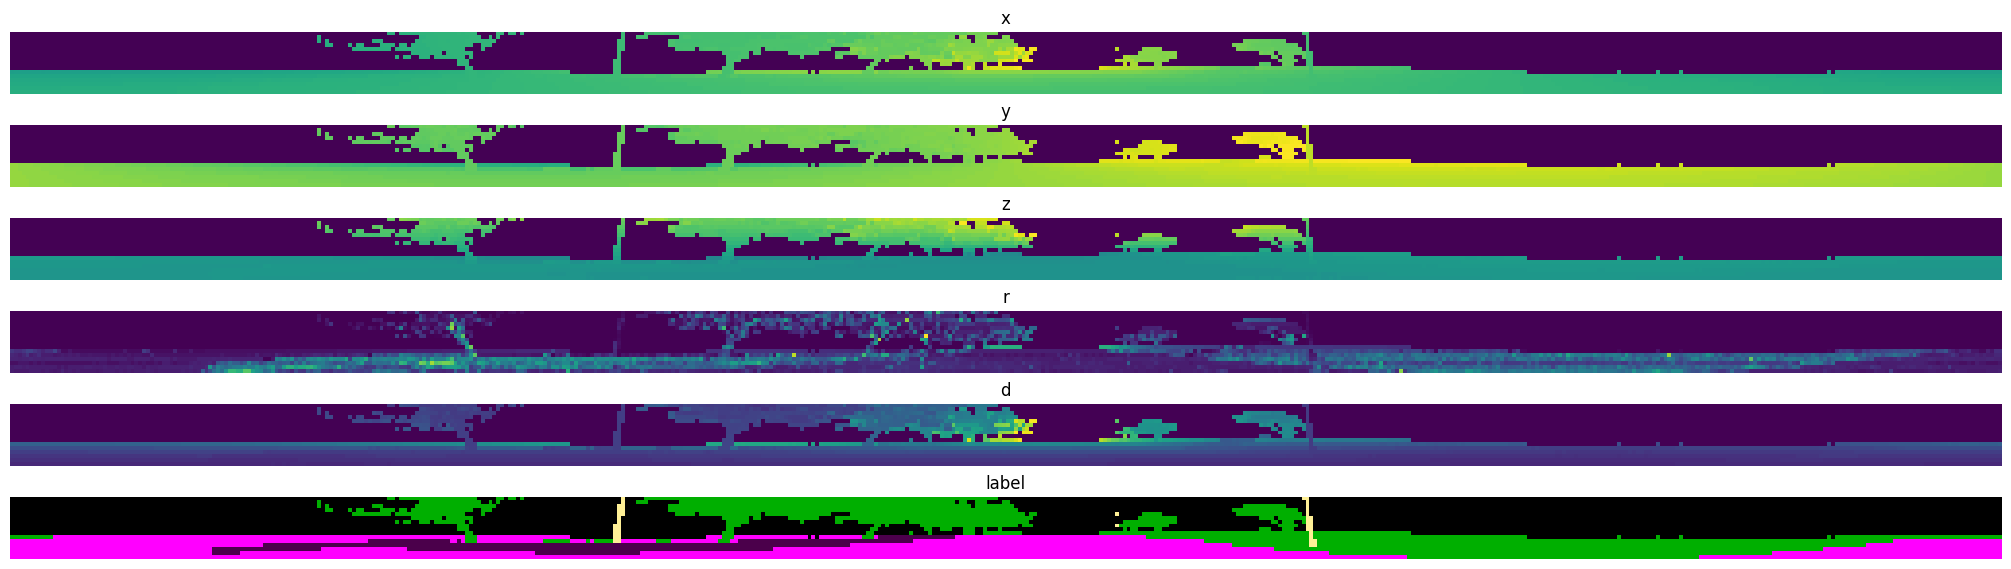

In [11]:
#| eval: false
proj = SphericalProjection(fov_up_deg=16., fov_down_deg=-16., W=512, H=16)  # these values were taken from [https://github.com/PRBonn/semantic-kitti-api/blob/master/auxiliary/laserscan.py]
scaling_values = {
    "x" : {"min": -100., "max":100.},
    "y" : {"min": -100., "max":100.},
    "z" : {"min": -10., "max":30.},
    "r" : {"min": 0., "max":1.},
    "d" : {"min": 0., "max":130.}
}
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np, scaling_values),
])
ds.set_transform(tfms)
item = ds[0]
img = item['frame']
label = item['label']

plot_projections(img, label)

In [13]:
#| hide
import nbdev; nbdev.nbdev_export()